# Toronto neighborhood analysis for an Indian family to live in 

## 1. Introduction

**City of Toronto** is the most populous city in Canada. It is home to various ethnic groups such as Canadian, English, Chinese, Indian, Italian etc. It is recognized as one of the most multicultural and cosmopolitan cities in the world.

Toronto is an international center of business, finance and culture. The business and employment opportunities in Toronto leads to temporary or permanent immigration of many families. There is also a lot of internal migration from within Canada to Toronto. Reasons can be economic, arts, better standard of living, etc.

Migrating to a new city is not a simple task. One has to consider multiple facets while choosing a neighborhood to settle ex: Proximity to schools, colleges, hospitals, banks, hotels, etc. These are some of the basic important factors which a person should consider whenever he/she tries to relocate to a new city.

In this report, we will focus on Indian families that are planning to move to the great city of Toronto. 

## 2. Problem Statement

<h3>Enable an Indian family to select a neigbhorhood to relocate in the city of Toronto.</h3>
    
By reading this report, an Indian family can compare different neighborhoods and they should get an idea of the neighborhoods that they can consider for relocating in Toronto.

## 3. Data acquisition and preparation

<h3>A.</h3>We need to identify all the neighborhoods in the city of Toronto. Neighborhood details according to postal codes are available on the following wiki page https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050.

In [106]:
# @hidden_cell
import pandas as pd # library for data analsysis

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import numpy as np # library to handle data in a vectorized manner

from matplotlib import pyplot
import seaborn as sns # Library for visualization
import matplotlib.pyplot as plt
%matplotlib inline

print ("Libraries imported successfully")

Libraries imported successfully


In [107]:
url = 'https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050'

df = pd.read_html(url, header=0)[0] # read an html table and load it into a dataframe
print (df.shape)
df.head()

(287, 3)


,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


#### Remove the entries with no neighborhoods

In [108]:
df.rename(columns = {'Neighbourhood':'Neighborhood','Postcode':'Postal Code'}, inplace = True) 
df['Neighborhood'].replace('Not assigned',np.nan, inplace=True) # Replace text NaN with np.nan
df.dropna(axis=0, inplace=True)  # drop rows where NAN
df.reset_index(drop=True, inplace=True)
print (df.shape)
df.head()

(210, 3)


,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


#### More than one neighborhood can exist in one postal code area. Combine neighbouhood with comma for each postal code. 

In [109]:
#Use Groupby on Postcode and Borough and apply String join function on Neigbourhood (Refer w3schools python string join tutorial)
df = df.groupby(['Postal Code','Borough'])['Neighborhood'].apply(','.join).reset_index()
print (df.shape)
df.head()

(103, 3)


,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


<h3>B.</h3> We need to identify coordinates of each neighborhood. These are available at : http://cocl.us/Geospatial_data. 
This is a csv file that has the geographical coordinates of each postal code of Toronto



In [110]:
geo_data = pd.read_csv('http://cocl.us/Geospatial_data') # read csv having coordinate for postal code
geo_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


#### let's combine the neighborhoods with geograpical coordinates using Postal Code. 

In [111]:
df_with_geo_data = pd.merge(df, geo_data, left_on='Postal Code',right_on='Postal Code', how='inner') 
df_with_geo_data.drop(['Postal Code'], axis=1, inplace=True) # drop duplicate postal code column
print (df_with_geo_data.shape)
df_with_geo_data.head()

(103, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,Scarborough,Woburn,43.770992,-79.216917
4,Scarborough,Cedarbrae,43.773136,-79.239476


<h3>C.</h3> We need to identify important elements of each neighborhood such as schools, hospitals, parks etc. Since we are focusing on Indian family, it will be great if we could identify Hotels serving Indian food as well. This information can be accessed using third party Foursquare APIs.

**Foursquare** is a social location service that allows users to explore the world around them. Based on latitude and longitude, it will provide nearby services such as hotels, banks, stores, specific type of restaurants etc. A free Foursquare developer account has already been created for use.

#### Select categories to consider for evaluating a neighborhood.

For each neighbourhood identify the venues based on following categories: School, College & University,Bank, Hospital, Indian Restaurant, Grocery Store, SuperMarket, Shopping Mall and Pharmacy

Foursquare provides category ids for each venue category. These are available in their developer docs (https://developer.foursquare.com/docs/build-with-foursquare/categories/). Foursquare apis return accurate results when specified with correct category Ids.Following are the ids for our selected categories: 

- 4f4533804b9074f6e4fb0105 - Elementary school
- 4bf58dd8d48988d13d941735 - High school
- 4f4533814b9074f6e4fb0106 - Middle school
- 4f4533814b9074f6e4fb0107 - Nursery school
- 4bf58dd8d48988d10a951735 - Bank
- 4bf58dd8d48988d196941735 - Hospital
- 4bf58dd8d48988d10f941735 - Indian Restaurant
- 4bf58dd8d48988d118951735 - Grocery Store
- 52f2ab2ebcbc57f1066b8b46 - Supermarket
- 4bf58dd8d48988d10f951735 - Pharmacy


In [112]:
# @hidden_cell
CLIENT_ID = 'IES25B4UWY215FFF3QSWXE5TAAQYYB4RJCTKESOXNA0PUYGA' # your Foursquare ID
CLIENT_SECRET = 'M5ZPM1KX30PYQVQ3UW1ZRA4IIUHLVZVOQP53VOZJSFXUWYWG' # your Foursquare Secret
VERSION = '20200411' # Foursquare API version

#### Explore the neighborhoods and search for venues that belong to our category list within a radius of 1000 meters.

In [113]:
# For each given lattiude,longitude, explore the venue using foursquare api
# Convert output of api response into json and store the required information in a list
def exploreNeighborhood(names, latitudes, longitudes, radius, limit, categories):
    venues_list=[]
    #For each selected neighbourhood, explore it using foursquare explore api
    for name,lat,long in zip(names,latitudes,longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
           CLIENT_ID,CLIENT_SECRET,VERSION,lat,long,radius,limit,categories)
        
        results = requests.get(url).json()
        if len(results["response"]) == 0:
            continue
            
        results = results["response"]['venues'] # parse the result to get items/venues
        venues_list.append([(
            name, 
            lat, 
            long, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results])
      
    print ("Data fetched succesfully.")
    return (venues_list)

In [114]:
Toronto_df = df_with_geo_data
categories = '4bf58dd8d48988d10f941735,4f4533804b9074f6e4fb0105,4bf58dd8d48988d13d941735,4f4533814b9074f6e4fb0106,4f4533814b9074f6e4fb0107,4bf58dd8d48988d10a951735,4bf58dd8d48988d196941735,4bf58dd8d48988d118951735,52f2ab2ebcbc57f1066b8b46,4bf58dd8d48988d10f951735'
radius=1000
limit=50 # Number of venues per search
exploration_results = exploreNeighborhood(Toronto_df['Neighborhood'],Toronto_df['Latitude'],Toronto_df['Longitude'],radius,limit,categories)


Data fetched succesfully.


#### Convert data into a dataframe

In [115]:

Toronto_venues = pd.DataFrame([item for venue_list in exploration_results for item in venue_list]) # add each item in venue list to dataframe,
Toronto_venues.columns = ['Neighborhood', 
              'Neighborhood Latitude', 
              'Neighborhood Longitude', 
              'Venue', 
              'Venue Latitude', 
              'Venue Longitude', 
              'Venue Category']
print ("Data converted successfully")

Data converted successfully


#### let's check our data

In [116]:
print ("Total number or rows="+str(Toronto_venues.shape[0]) + " and Total number of columns = "+str(Toronto_venues.shape[1]))
print ("Example:")
Toronto_venues.head(10)

Total number or rows=2753 and Total number of columns = 7
Example:


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge,Malvern",43.806686,-79.194353,Alvin Curling Public School,43.808683,-79.190103,Elementary School
1,"Rouge,Malvern",43.806686,-79.194353,Obsidian Mortgage Corporation & Financial Serv...,43.801100,-79.194131,Bank
2,"Rouge,Malvern",43.806686,-79.194353,Fusion supermart,43.800434,-79.200439,Grocery Store
3,"Rouge,Malvern",43.806686,-79.194353,Pharmasave,43.800724,-79.199822,Pharmacy
4,"Rouge,Malvern",43.806686,-79.194353,Seamless Care Pharmacy,43.799988,-79.195700,Pharmacy
5,"Rouge,Malvern",43.806686,-79.194353,Fusion Supermarket,43.800528,-79.200064,Supermarket
6,"Rouge,Malvern",43.806686,-79.194353,Meena's Fine Foods,43.804476,-79.199753,Indian Restaurant
7,"Rouge,Malvern",43.806686,-79.194353,RBC Royal Bank,43.798782,-79.197090,Bank
8,"Rouge,Malvern",43.806686,-79.194353,St Columba Catholic School,43.803955,-79.207889,Elementary School
9,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Cibc,43.783435,-79.170464,Bank


In [117]:
Toronto_venues['Venue Category'].value_counts()

Bank                         660
Pharmacy                     535
Grocery Store                484
Indian Restaurant            264
Hospital                     168
High School                  161
Elementary School            150
Supermarket                  106
Middle School                 35
Cosmetics Shop                25
Office                        21
Nursery School                20
Hospital Ward                 12
School                         8
Credit Union                   8
Health Food Store              6
Farmers Market                 6
Gourmet Shop                   6
South Indian Restaurant        6
Food & Drink Shop              5
Doctor's Office                5
Indian Chinese Restaurant      4
Butcher                        4
North Indian Restaurant        4
Snack Place                    3
Big Box Store                  3
Convenience Store              3
Emergency Room                 3
ATM                            3
Event Space                    2
Supplement

#### Clean up the data for unwanted categories and merge similar categories

**#** Filter results to include specific categories

In [118]:
include_results = ["Bank","Pharmacy","Grocery Store","Indian Restaurant","South Indian Restaurant","North Indian Restaurant","Hospital","High School","Elementary School","Supermarket","Middle School","Nursery School","Hospital Ward","School","Health Food Store","Farmers Market","Gourmet Shop","Food & Drink Shop","Doctor's Office","Indian Chinese Restaurant","Convenience Store","Emergency Room","Medical Center","Chaat Place","Market","Fruit & Vegetable Store","Drugstore"]
filtered_Toronto_venues = Toronto_venues[Toronto_venues['Venue Category'].isin(include_results)]

filtered_Toronto_venues['Venue Category'].value_counts()

Bank                         660
Pharmacy                     535
Grocery Store                484
Indian Restaurant            264
Hospital                     168
High School                  161
Elementary School            150
Supermarket                  106
Middle School                 35
Nursery School                20
Hospital Ward                 12
School                         8
Gourmet Shop                   6
South Indian Restaurant        6
Farmers Market                 6
Health Food Store              6
Doctor's Office                5
Food & Drink Shop              5
Indian Chinese Restaurant      4
North Indian Restaurant        4
Emergency Room                 3
Convenience Store              3
Chaat Place                    2
Medical Center                 2
Market                         2
Drugstore                      1
Fruit & Vegetable Store        1
Name: Venue Category, dtype: int64

In [119]:
filtered_Toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge,Malvern",43.806686,-79.194353,Alvin Curling Public School,43.808683,-79.190103,Elementary School
1,"Rouge,Malvern",43.806686,-79.194353,Obsidian Mortgage Corporation & Financial Serv...,43.801100,-79.194131,Bank
2,"Rouge,Malvern",43.806686,-79.194353,Fusion supermart,43.800434,-79.200439,Grocery Store
3,"Rouge,Malvern",43.806686,-79.194353,Pharmasave,43.800724,-79.199822,Pharmacy
4,"Rouge,Malvern",43.806686,-79.194353,Seamless Care Pharmacy,43.799988,-79.195700,Pharmacy


**#** Give a common label to similar categories. Example: "Indian Restaurant","South Indian Restaurant","North Indian Restaurant" and "Indian Chinese Restaurant" can be given a common label as "Indian Restaurant"

In [120]:
filtered_Toronto_venues_processed = filtered_Toronto_venues

#replace sub categories of indian restaurants with "Indian Restaurant"
filtered_Toronto_venues_processed['Venue Category'].replace(["Indian Restaurant","South Indian Restaurant","North Indian Restaurant","Indian Chinese Restaurant","Chaat Place"], "Indian Restaurant", inplace=True)
#replace food store categories with "Food store"
filtered_Toronto_venues_processed['Venue Category'].replace(["Grocery Store","Fruit & Vegetable Store","Food & Drink Shop","Gourmet Shop","Farmers Market","Health Food Store"],"Food store", inplace=True)
#replace medical entities with "Medical Center"
filtered_Toronto_venues_processed['Venue Category'].replace(["Pharmacy","Drugstore","Hospital","Hospital Ward","Doctor's Office","Emergency Room","Medical Center"], "Medical Center", inplace=True)
#replace school types with "School"
filtered_Toronto_venues_processed['Venue Category'].replace(["High School","Elementary School","Middle School","Nursery School","School"], "School", inplace=True)
#replace types of markets with "Supermarket"
filtered_Toronto_venues_processed['Venue Category'].replace(["Supermarket","Convenience Store","Market"], "Supermarket", inplace=True)

print("Updated categories to Common labels")
filtered_Toronto_venues_processed['Venue Category'].value_counts()



Updated categories to Common labels


Medical Center       726
Bank                 660
Food store           508
School               374
Indian Restaurant    280
Supermarket          111
Name: Venue Category, dtype: int64

In [121]:
print ("Total number or rows in the processed data = "+str(filtered_Toronto_venues_processed.shape[0]) + " and Total number of columns = "+str(filtered_Toronto_venues_processed.shape[1]))
filtered_Toronto_venues_processed.head()

Total number or rows in the processed data = 2659 and Total number of columns = 7


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge,Malvern",43.806686,-79.194353,Alvin Curling Public School,43.808683,-79.190103,School
1,"Rouge,Malvern",43.806686,-79.194353,Obsidian Mortgage Corporation & Financial Serv...,43.801100,-79.194131,Bank
2,"Rouge,Malvern",43.806686,-79.194353,Fusion supermart,43.800434,-79.200439,Food store
3,"Rouge,Malvern",43.806686,-79.194353,Pharmasave,43.800724,-79.199822,Medical Center
4,"Rouge,Malvern",43.806686,-79.194353,Seamless Care Pharmacy,43.799988,-79.195700,Medical Center


# TODO: you can use visualization to show distribution on filtered_Toronto_venues_processed

#### Use One Hot Encoding on Venue Category to convert categorical values in columns and mark the venue in the appropriate column

In [122]:
# Execute one hot encode on 'Venue Category'
dummies = pd.get_dummies(filtered_Toronto_venues_processed['Venue Category'])
# Merge the identified dummies with neighborhoods
Toronto_venues_temp = pd.concat([filtered_Toronto_venues_processed,dummies],axis=1)
# remove 'Venue Category','Neighborhood Latitude','Neighborhood Longitude','Venue Latitude','Venue Longitude' column as it has been one hot encoded
Toronto_venues_temp.drop(['Venue Category','Neighborhood Latitude','Neighborhood Longitude','Venue Latitude','Venue Longitude',],axis=1,inplace=True) 
Toronto_venues_temp.head()


,Neighborhood,Venue,Bank,Food store,Indian Restaurant,Medical Center,School,Supermarket
0,"Rouge,Malvern",Alvin Curling Public School,0,0,0,0,1,0
1,"Rouge,Malvern",Obsidian Mortgage Corporation & Financial Serv...,1,0,0,0,0,0
2,"Rouge,Malvern",Fusion supermart,0,1,0,0,0,0
3,"Rouge,Malvern",Pharmasave,0,0,0,1,0,0
4,"Rouge,Malvern",Seamless Care Pharmacy,0,0,0,1,0,0


#### Find number of venues per category for each neighborhood

In [123]:
Toronto_grouped = Toronto_venues_temp.groupby('Neighborhood').sum().reset_index()
print ("Total number or rows in the grouped data = "+str(Toronto_grouped.shape[0]) + " and Total number of columns = "+str(Toronto_grouped.shape[1]))
Toronto_grouped.head(10)

Total number or rows in the grouped data = 101 and Total number of columns = 7


,Neighborhood,Bank,Food store,Indian Restaurant,Medical Center,School,Supermarket
0,"Adelaide,King,Richmond",6,8,4,24,1,4
1,Agincourt,4,4,3,3,1,3
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",3,2,0,6,5,0
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",2,4,4,8,5,0
4,"Alderwood,Long Branch",7,3,1,7,2,1
5,"Bathurst Manor,Downsview North,Wilson Heights",4,1,0,1,2,1
6,Bayview Village,4,3,0,1,1,0
7,"Bedford Park,Lawrence Manor East",7,1,4,1,3,0
8,Berczy Park,11,10,6,14,0,2
9,"Birch Cliff,Cliffside West",0,0,4,1,2,0


#### Since we are doing this study for an Indian family, we will not consider the neighborhoods with zero Indian Restaurants

In [124]:
Toronto_grouped['Indian Restaurant'].replace(0,np.nan,inplace=True)
Toronto_grouped.dropna(axis=0, inplace=True)  # drop rows where NAN
Toronto_grouped['Indian Restaurant'] = Toronto_grouped['Indian Restaurant'].astype('int64')
Toronto_grouped.reset_index(drop=True, inplace=True)
print ("Total number or rows in the grouped data = "+str(Toronto_grouped.shape[0]) + " and Total number of columns = "+str(Toronto_grouped.shape[1]))
Toronto_grouped.head(10)

Total number or rows in the grouped data = 75 and Total number of columns = 7


,Neighborhood,Bank,Food store,Indian Restaurant,Medical Center,School,Supermarket
0,"Adelaide,King,Richmond",6,8,4,24,1,4
1,Agincourt,4,4,3,3,1,3
2,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",2,4,4,8,5,0
3,"Alderwood,Long Branch",7,3,1,7,2,1
4,"Bedford Park,Lawrence Manor East",7,1,4,1,3,0
5,Berczy Park,11,10,6,14,0,2
6,"Birch Cliff,Cliffside West",0,0,4,1,2,0
7,"Brockton,Exhibition Place,Parkdale Village",13,9,8,13,2,3
8,Business Reply Mail Processing Centre 969 Eastern,5,4,9,2,2,0
9,"Cabbagetown,St. James Town",8,10,3,17,8,3


#### Let's visualize our neighborhoods for top 20 venues per category

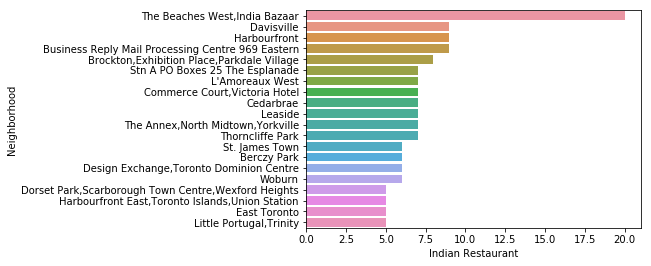

In [125]:
sns.barplot(y="Neighborhood", x="Indian Restaurant",data=Toronto_grouped.sort_values("Indian Restaurant",ascending=False)[0:20]);

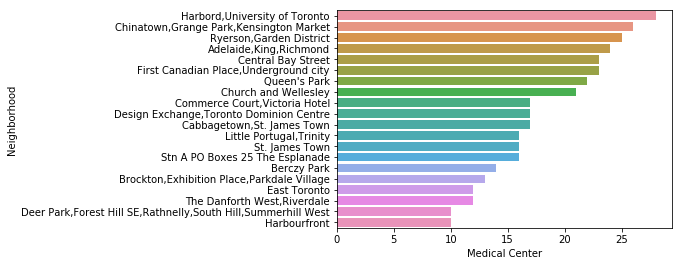

In [126]:
sns.barplot(y="Neighborhood", x="Medical Center",data=Toronto_grouped.sort_values("Medical Center",ascending=False)[0:20]);

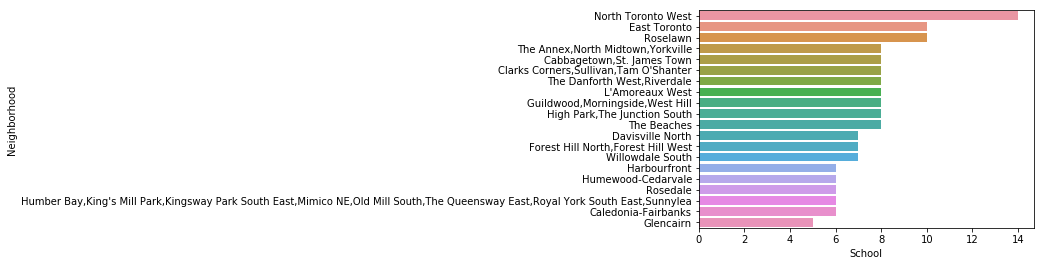

In [127]:
sns.barplot(y="Neighborhood", x="School",data=Toronto_grouped.sort_values("School",ascending=False)[0:20]);

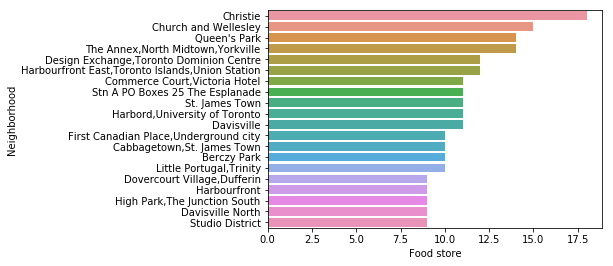

In [128]:
sns.barplot(y="Neighborhood", x="Food store",data=Toronto_grouped.sort_values("Food store",ascending=False)[0:20]);

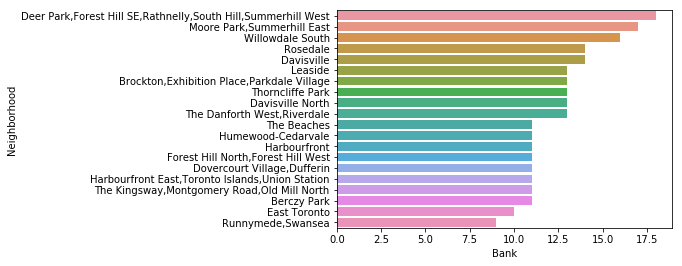

In [129]:
sns.barplot(y="Neighborhood", x="Bank",data=Toronto_grouped.sort_values("Bank",ascending=False)[0:20]);

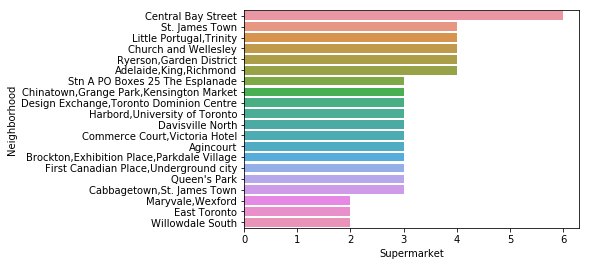

In [130]:
sns.barplot(y="Neighborhood", x="Supermarket",data=Toronto_grouped.sort_values("Supermarket",ascending=False)[0:20]);

#### As the final step in data preparation, we will join the neighborhood venue data with geographical coordinates data

In [131]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = df_with_geo_data
Toronto_merged = Toronto_merged.join(Toronto_grouped.set_index('Neighborhood'), on='Neighborhood',how='inner')
print ("Total number or rows in the data = "+str(Toronto_merged.shape[0]) + " and Total number of columns = "+str(Toronto_merged.shape[1]))
Toronto_merged.head()

Total number or rows in the data = 75 and Total number of columns = 10


,Borough,Neighborhood,Latitude,Longitude,Bank,Food store,Indian Restaurant,Medical Center,School,Supermarket
0,Scarborough,"Rouge,Malvern",43.806686,-79.194353,2,1,1,2,2,1
2,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,6,1,3,6,8,2
3,Scarborough,Woburn,43.770992,-79.216917,3,1,6,3,2,0
4,Scarborough,Cedarbrae,43.773136,-79.239476,7,4,7,7,2,0
5,Scarborough,Scarborough Village,43.744734,-79.239476,6,3,1,5,2,0


## 4. Methodology

Using the essential venue categories, we can divide the neighborhoods into different segments: **Excellent, Good, Moderate, Poor**.
This will help an individual make a decision on which neighborhood to select.